In [1]:
import generate_data as gd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import math
import time
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectPercentile, VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from skfeature.function.similarity_based import fisher_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from filters import lda,knn, run_filters
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV, RFE

from IPython.display import Audio
sound_file = './db.mp3'

import pylab
import warnings
warnings.filterwarnings('ignore')
pylab.rcParams['figure.figsize'] = (8.0, 8.0)

## Original Classification using KNN

In [3]:
def orig_class(X_train, X_test, y_train, y_test, class_alg=LinearDiscriminantAnalysis()):
  
    start_t = time.time()
    model = class_alg.fit(X_train,y_train)

    y_test_pred = model.predict(X_test)

    orig_acc = accuracy_score(y_test, y_test_pred)
    orig_time = time.time() - start_t

    return orig_time, orig_acc

### Variance Threshold feature selection and classification

In [4]:
def vt_feat_sel(X_train, X_test, y_train, y_test, class_alg=LinearDiscriminantAnalysis()):

    t_start = time.time()
    var = np.zeros(len(X_train[0,:]))
  
    for i in range(len(X_train[0,:])):
    
        var[i] = np.var(X_train[:,i])
    
        ind_max_var = np.argsort(var)
  
    vt_acc = np.zeros(len(X_train[0,:]))
  
    for i in range(len(X_train[0,:])):
    
        X_temp = X_train[:,ind_max_var[0:(i+1)]]
        X_test_temp = X_test[:,ind_max_var[0:(i+1)]]

        class_alg.fit(X_temp, y_train)

        y_test_pred = class_alg.predict(X_test_temp)
        vt_acc[i] = accuracy_score(y_test, y_test_pred, normalize=True)
    
    vt_time = time.time()-t_start  
    vt_max_acc = max(vt_acc)
    vt_selected_features = np.argmax(vt_acc)

    return vt_time, vt_max_acc, vt_selected_features + 1

In [5]:
def vt_feat_sel_seb(X_train, X_test, y_train, y_test, th=34, class_alg=LinearDiscriminantAnalysis()):
    t_start = time.time()
    
    sel = VarianceThreshold(threshold=th)
    X_train_fs = sel.fit_transform(X_train)
    X_test_fs = X_test[:,:X_train_fs.shape[1]]
    
    class_alg.fit(X_train_fs, y_train)
    y_test_pred = class_alg.predict(X_test_fs)
    acc = accuracy_score(y_test, y_test_pred, normalize=True)
    
    vt_time = time.time()-t_start 
    
    return vt_time, acc, X_train_fs.shape[1]
    

### Recursive Feature Elimination

In [6]:
def rfe_feat_sel(X_train, X_test, y_train, y_test,\
                  class_alg=LinearDiscriminantAnalysis(), folds=5):

    t_start = time.time()
    # Train model
    rfecv = RFECV(class_alg, cv=folds)
    rfecv = rfecv.fit(X_train, y_train)

    rfe_time = time.time() - t_start

    scores = rfecv.grid_scores_[0:25]
    rfe_selected_features = np.argmax(scores)

    # Train model with optimal k
    rfe = RFE(class_alg,rfe_selected_features + 1)
    rfe = rfe.fit(X_train, y_train)

    y_test_pred = rfe.predict(X_test)
    rfe_acc = accuracy_score(y_test, y_test_pred)

    return rfe_time, rfe_acc, rfe_selected_features

### Sequential Forward/Backward Selection

In [7]:
def seq_feat_sel(X_train, X_test, y_train, y_test, num_feat = 30,\
                 forward_sfs=True, class_alg=LinearDiscriminantAnalysis(), folds=5):
    
    start = time.time()
    sfs = SFS(class_alg,
           k_features=(1, num_feat - 5),
           forward=forward_sfs,
           floating=False,
           verbose=0,
           scoring='accuracy',
           cv=folds)
    sfs = sfs.fit(X_train, y_train)
    end = time.time()
    sfs_time = end-start
    
    # Accuracy for test data
    wrap_feat_sfs = list(sfs.k_feature_idx_)
    class_alg.fit(X_train[:, wrap_feat_sfs], y_train)
    y_test_pred = class_alg.predict(X_test[:, wrap_feat_sfs])
    sfs_acc = accuracy_score(y_test, y_test_pred)
    
    return sfs_time, sfs_acc, len(wrap_feat_sfs)

## Filter & Wrapping Evaluation

In [8]:
nr_features=15
nr_classes= np.array([10,20,30,40,50])
nr_points = 500
variance_size = 8
runs = 10

# Filters
f_score_accs = np.zeros([runs, len(nr_classes)])
mi_accs = np.zeros([runs, len(nr_classes)])
chi2_accs = np.zeros([runs, len(nr_classes)])
vt_accs = np.zeros([runs, len(nr_classes)])
orig_accs = np.zeros([runs, len(nr_classes)])

f_score_times =  np.zeros([runs, len(nr_classes)])
mi_times = np.zeros([runs, len(nr_classes)])
chi2_times = np.zeros([runs, len(nr_classes)])
vt_times = np.zeros([runs, len(nr_classes)])
orig_times = np.zeros([runs, len(nr_classes)])

# Wrapping Methods
sfs_accs = np.zeros([runs, len(nr_classes)])
sbs_accs = np.zeros([runs, len(nr_classes)])
rfe_accs = np.zeros([runs, len(nr_classes)])

sfs_times = np.zeros([runs, len(nr_classes)])
sbs_times = np.zeros([runs, len(nr_classes)])
rfe_times = np.zeros([runs, len(nr_classes)])

for iRun in range(runs):
    
    print("========= Dataset: {} ==========".format(iRun+1))
    
    for i,nc in enumerate(nr_classes):

        X,y = gd.gaussian_clusters(nr_features, nr_classes=nc, \
                               nr_data_points=nr_points, random_diag=True, variance_size=variance_size, seed=iRun)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=iRun)
        orig_time, orig_acc = orig_class(X_train, X_test, y_train, y_test, class_alg=LinearDiscriminantAnalysis())

        print("========= Num Classes {} ==========".format(nc))


        # =============== Filters ===============
        best_ks, best_scores, times, f_scores_filtered_knn, f_scores_filtered_lda, mi_scores_filtered_knn, \
        mi_scores_filtered_lda, chi2_scores_filtered_knn, \
        chi2_scores_filtered_lda = run_filters(X_train, y_train, X_test, y_test, only_lda=True)
        vt_time, vt_acc, vt_num_feat = vt_feat_sel_seb(X_train, X_test, y_train, y_test)

        # Accuracy
        f_score_accs[iRun, i] = np.max(f_scores_filtered_lda)
        mi_accs[iRun, i] = np.max(mi_scores_filtered_lda)
        chi2_accs[iRun, i] = np.max(chi2_scores_filtered_lda)
        vt_accs[iRun, i] = np.max(vt_acc)
        orig_accs[iRun, i] = orig_acc

        #  Times
        f_score_times[iRun, i] = times[3]
        mi_times[iRun, i] = times[4]
        chi2_times[iRun, i] = times[5]
        orig_times[iRun, i] = orig_time
        vt_times[iRun, i] = vt_time

        # =============== Wrapping ===============
        sfs_time, sfs_acc, rfe_selected_features = seq_feat_sel(X_train, X_test, y_train, y_test, num_feat=10, forward_sfs=True)
        sbs_time, sbs_acc, sbs_selected_features = seq_feat_sel(X_train, X_test, y_train, y_test, num_feat=10, forward_sfs=False)
        rfe_time, rfe_acc, rfe_selected_features = rfe_feat_sel(X_train, X_test, y_train, y_test)

        # Accuracy
        sfs_accs[iRun, i] = sfs_acc
        sbs_accs[iRun, i] = sbs_acc
        rfe_accs[iRun, i] = rfe_acc
        orig_accs[iRun, i] = orig_acc

        # Times
        sfs_times[iRun, i] = sfs_time
        sbs_times[iRun, i] = sbs_time
        rfe_times[iRun, i] = rfe_time
        orig_times[iRun, i] = orig_time
    
print("Run Complete!") 
Audio(sound_file, autoplay=True)

========= Dataset: 1 ==========
========= Num Classes 10 ==========
========= Num Classes 20 ==========
========= Num Classes 30 ==========
========= Num Classes 40 ==========
========= Num Classes 50 ==========
========= Dataset: 2 ==========
========= Num Classes 10 ==========
========= Num Classes 20 ==========
========= Num Classes 30 ==========
========= Num Classes 40 ==========
========= Num Classes 50 ==========
========= Dataset: 3 ==========
========= Num Classes 10 ==========
========= Num Classes 20 ==========
========= Num Classes 30 ==========
========= Num Classes 40 ==========
========= Num Classes 50 ==========
========= Dataset: 4 ==========
========= Num Classes 10 ==========
========= Num Classes 20 ==========
========= Num Classes 30 ==========
========= Num Classes 40 ==========
========= Num Classes 50 ==========
========= Dataset: 5 ==========
========= Num Classes 10 ==========
========= Num Classes 20 ==========
========= Num Classes 30 ==========
========= Nu

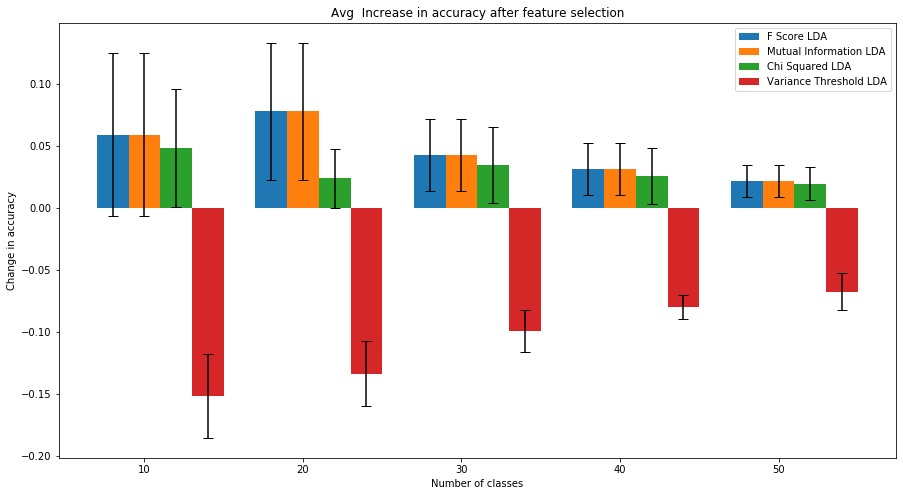

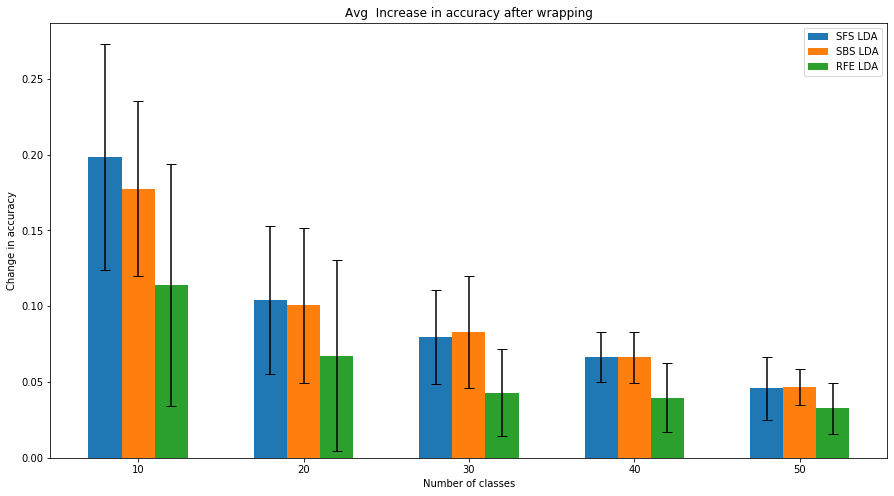

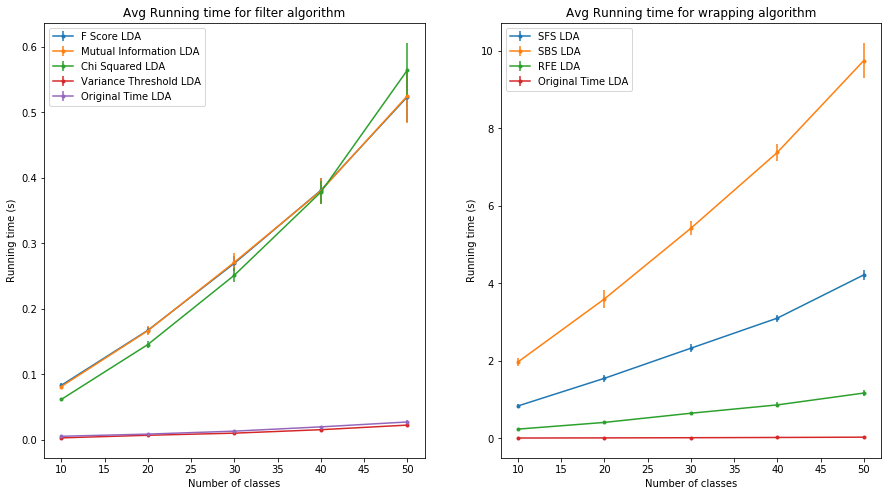

In [11]:
# ================== Accuracy ==================
plt.figure(figsize=(15,8))
bw = 0.2
xs = np.array(range(len(nr_classes)))
plt.title("Avg  Increase in accuracy after feature selection")
plt.bar(xs - bw, np.mean(f_score_accs-orig_accs, axis=0), yerr=np.std(f_score_accs-orig_accs, axis=0), label="F Score LDA", width=bw, align='center', capsize=5)
plt.bar(xs, np.mean(mi_accs-orig_accs, axis=0), yerr=np.std(mi_accs-orig_accs, axis=0), label="Mutual Information LDA",width=bw,align='center', capsize=5)
plt.bar(xs +bw, np.mean(chi2_accs-orig_accs, axis=0), yerr=np.std(chi2_accs-orig_accs, axis=0), label="Chi Squared LDA",width=bw, align='center', capsize=5)
plt.bar(xs +bw*2, np.mean(vt_accs-orig_accs, axis=0),  yerr=np.std(vt_accs-orig_accs, axis=0), label="Variance Threshold LDA",width=bw, align='center', capsize=5)
plt.legend()
plt.xlabel('Number of classes')
plt.ylabel('Change in accuracy')
plt.xticks(xs, nr_classes)
plt.show()

plt.figure(figsize=(15,8))
plt.title("Avg  Increase in accuracy after wrapping")
plt.bar(xs-bw, np.mean(sfs_accs-orig_accs, axis=0), yerr=np.std(sfs_accs-orig_accs, axis=0), label="SFS LDA", width=bw, align='center', capsize=5)
plt.bar(xs, np.mean(sbs_accs-orig_accs, axis=0), yerr=np.std(sbs_accs-orig_accs, axis=0), label="SBS LDA",width=bw, capsize=5)
plt.bar(xs+bw, np.mean(rfe_accs-orig_accs, axis=0), yerr=np.std(rfe_accs-orig_accs, axis=0), label="RFE LDA",width=bw, capsize=5)
plt.legend()
plt.xlabel("Number of classes")
plt.ylabel("Change in accuracy")
plt.xticks(xs, nr_classes)
plt.show()


# ================== Running Time ==================

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

f.figsize = (15,8)

ax1.set_title("Avg Running time for filter algorithm")
ax1.errorbar(nr_classes, np.mean(f_score_times, axis=0), yerr=np.std(f_score_times, axis=0), marker='.', label="F Score LDA")
ax1.errorbar(nr_classes, np.mean(mi_times, axis=0), yerr=np.std(mi_times, axis=0) , marker='.', label="Mutual Information LDA")
ax1.errorbar(nr_classes, np.mean(chi2_times, axis=0), yerr=np.std(chi2_times, axis=0) , marker='.', label="Chi Squared LDA")
ax1.errorbar(nr_classes, np.mean(vt_times, axis=0), yerr=np.std(vt_times, axis=0) , marker='.', label="Variance Threshold LDA")
ax1.errorbar(nr_classes, np.mean(orig_times, axis=0), yerr=np.std(orig_times, axis=0) , marker='.', label="Original Time LDA")
ax1.set_xlabel('Number of classes')
ax1.set_ylabel('Running time (s)')
ax1.legend()

ax2.set_title("Avg Running time for wrapping algorithm")
ax2.errorbar(nr_classes, np.mean(sfs_times, axis=0), yerr=np.std(sfs_times, axis=0) , marker='.', label="SFS LDA")
ax2.errorbar(nr_classes, np.mean(sbs_times, axis=0), yerr=np.std(sbs_times, axis=0) , marker='.', label="SBS LDA")
ax2.errorbar(nr_classes, np.mean(rfe_times, axis=0), yerr=np.std(rfe_times, axis=0) , marker='.', label="RFE LDA")
ax2.errorbar(nr_classes, np.mean(orig_times, axis=0), yerr=np.std(orig_times, axis=0) , marker='.', label="Original Time LDA")
ax2.set_xlabel("Number of classes")
ax2.set_ylabel("Running time (s)")
ax2.legend()

plt.show()

In [10]:

display(HTML("<h2>Filter Methods</h2>"))
filter_result_mat = np.zeros([4,len(nr_classes)])
filter_result_mat[0,:] = np.mean(f_score_accs-orig_accs, axis=0)
filter_result_mat[1,:] = np.mean(mi_accs-orig_accs, axis=0)
filter_result_mat[2,:] = np.mean(chi2_accs-orig_accs, axis=0)
filter_result_mat[3,:] = np.mean(vt_accs-orig_accs, axis=0)

df = pd.DataFrame(filter_result_mat)
df.index.name='Filtering Method'
df.columns = nr_classes
df.rename(index={0:'F score',1:'Mutual Information', 2: 'Chi Squared', 3: 'Variance Threshold'}, inplace=True)
df.columns.name = 'Number of classes'
display(df)


display(HTML("<h2>Wrapping Methods</h2>"))
wrapping_result_mat = np.zeros([3,len(nr_classes)])
wrapping_result_mat[0,:] = np.mean(sfs_accs-orig_accs, axis=0)
wrapping_result_mat[1,:] = np.mean(sbs_accs-orig_accs, axis=0)
wrapping_result_mat[2,:] = np.mean(rfe_accs-orig_accs, axis=0)

df = pd.DataFrame(wrapping_result_mat)
df.index.name='Wrapping Method'
df.columns = nr_classes
df.rename(index={0:'Sequential Forward Selection',1:'Sequential Backward Selection', 2: 'Recursive Feature Elimination'}, inplace=True)
df.columns.name = 'Number of classes'
display(df)

Number of classes,10,20,30,40,50
Filtering Method,,,,,
F score,0.058848,0.078000,0.042566,0.031485,0.021709
Mutual Information,0.058848,0.078000,0.042566,0.031485,0.021709
Chi Squared,0.048000,0.023697,0.034182,0.025621,0.019345
Variance Threshold,-0.151697,-0.133636,-0.099071,-0.080045,-0.067588


Number of classes,10,20,30,40,50
Wrapping Method,,,,,
Sequential Forward Selection,0.198545,0.104000,0.079717,0.066379,0.045976
Sequential Backward Selection,0.177394,0.100576,0.082848,0.066288,0.046800
Recursive Feature Elimination,0.114242,0.067333,0.043051,0.039742,0.032630
